## Simulation of TSLA Sale Off

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import pickle
from scipy.stats import norm
np.random.seed(972)

In [2]:
tsla = pd.read_csv("../BATS_TSLA.csv")

In [3]:
start_time = 1636381800
end_time = 1636732800

In [4]:
tsla = tsla[(tsla["time"] >= start_time)& (tsla["time"] <= end_time)]

In [5]:
tsla["datetime"] = tsla["time"].map(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')).values

In [6]:
tsla = tsla.set_index("datetime")

In [7]:
nine_day_vol = 0.5012

In [8]:
vol_scale = np.sqrt(9 / (30 / (60 * 24)))

In [9]:
local_vol = nine_day_vol / vol_scale

In [10]:
def impact_f(v: float, delta: float) -> float: ## assume power-law impact
    return np.sign(v) * np.abs(v) ** delta

def decay_G(v: float, gamma: float) -> float: 
    return v ** (-gamma)

In [11]:
with open('ham_record.pickle', 'rb') as handle:
    ham_dict = pickle.load(handle)

with open('sqp_record.pickle', 'rb') as handle:
    sqp_dict = pickle.load(handle)

In [12]:
N = 50

In [13]:
X = 0.166 #https://www.cnbc.com/2021/11/13/elon-musk-sells-another-1point2-billion-of-tesla-stock.html

In [14]:
tsla_sample = tsla.iloc[::6,:].iloc[:50,:]
sigma = local_vol
wiener_process = [norm.rvs(scale = sigma) for _ in range(N)]

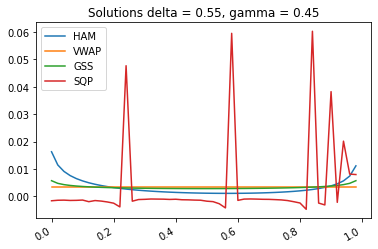

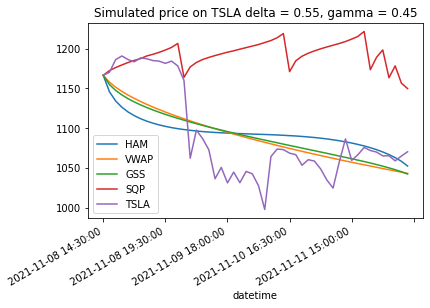

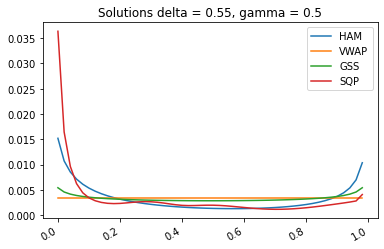

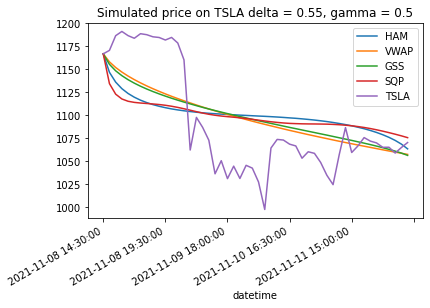

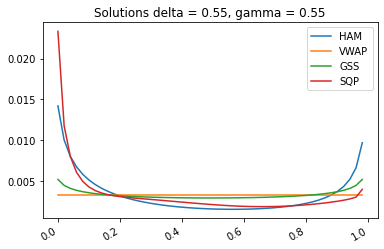

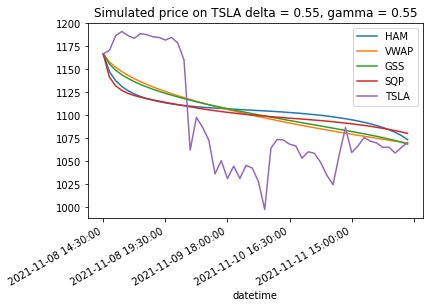

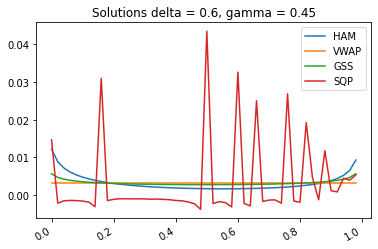

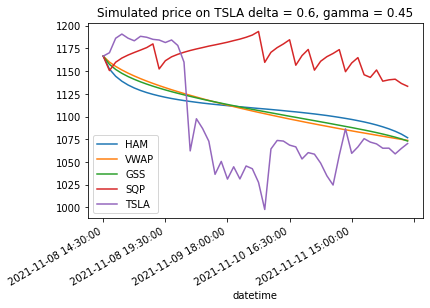

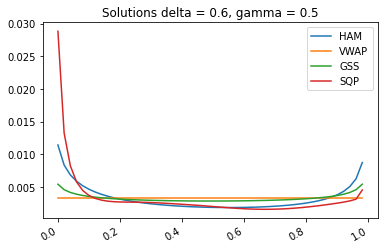

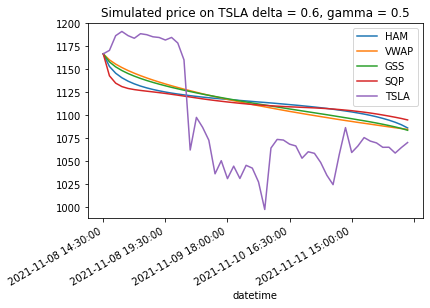

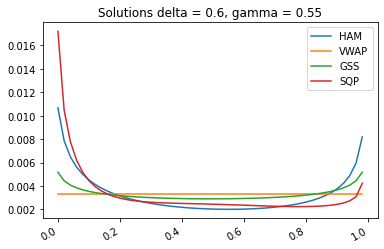

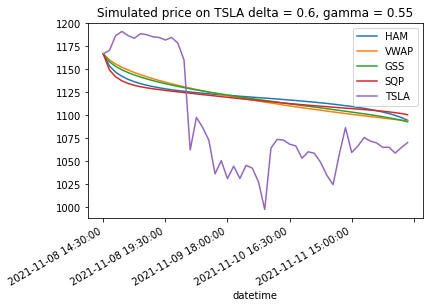

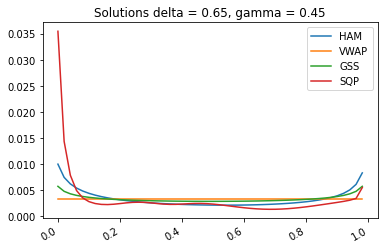

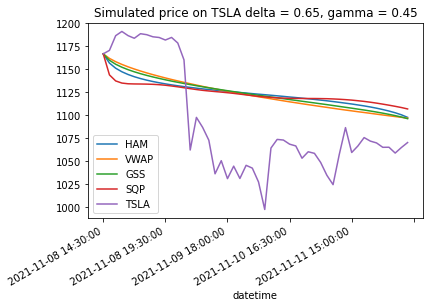

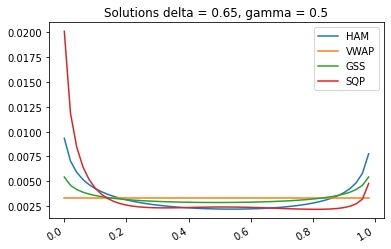

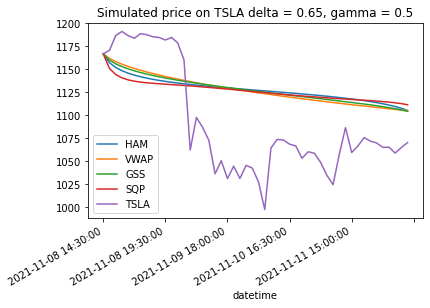

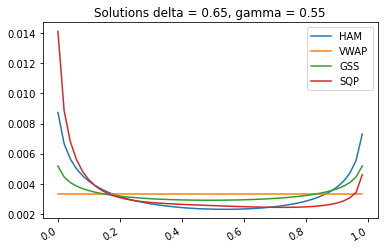

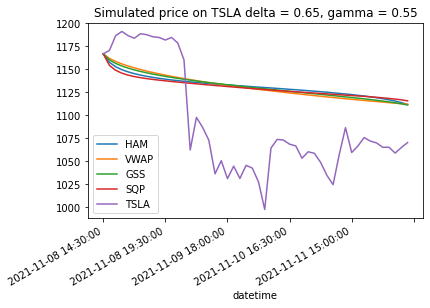

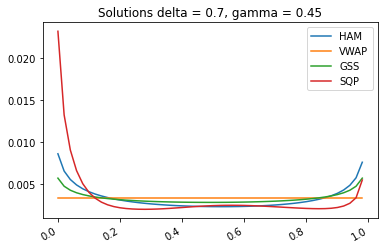

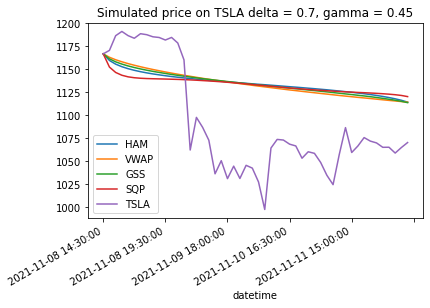

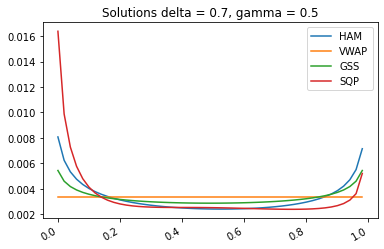

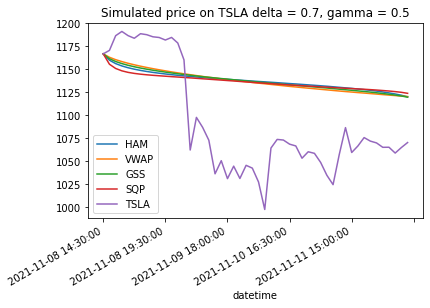

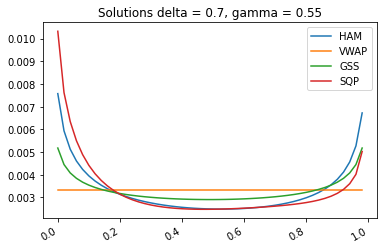

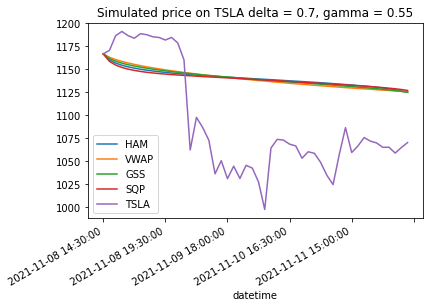

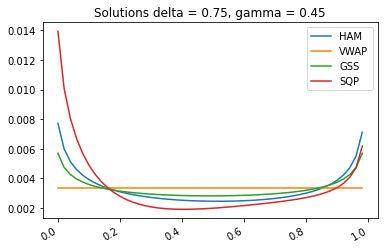

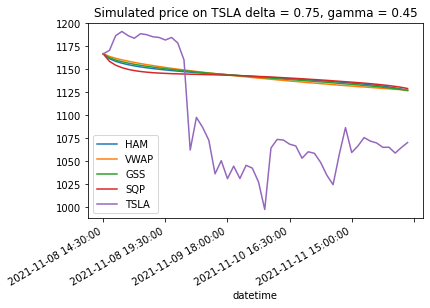

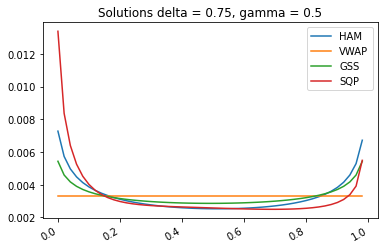

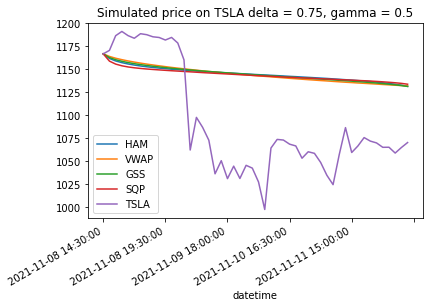

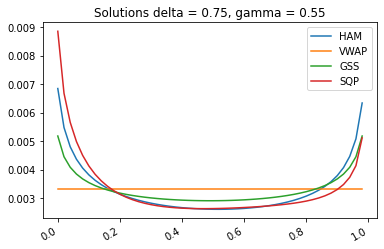

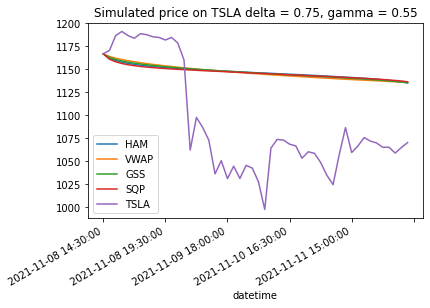

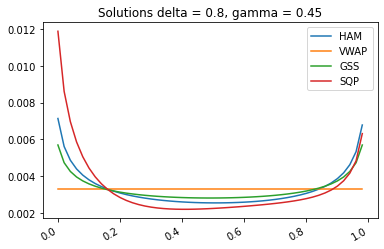

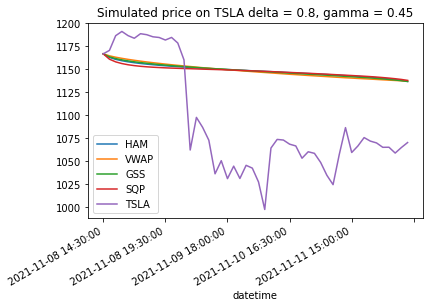

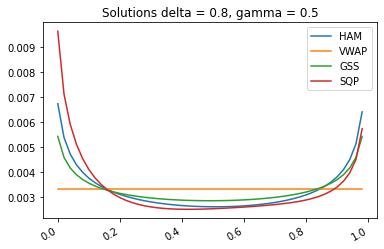

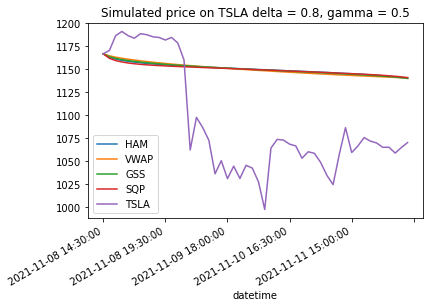

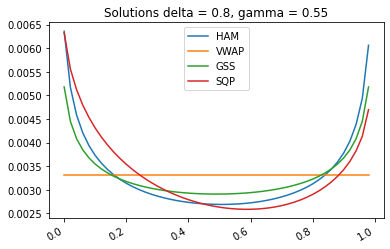

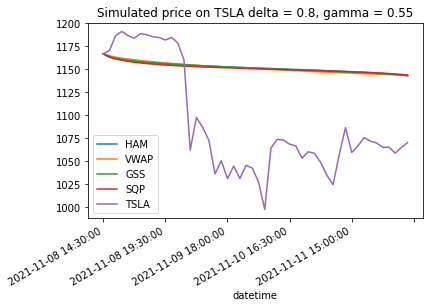

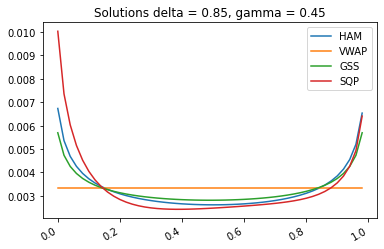

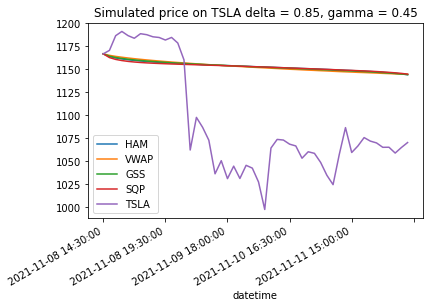

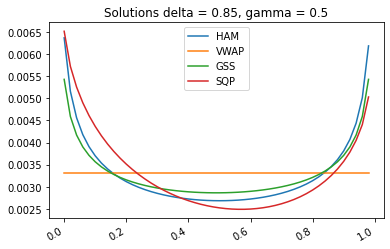

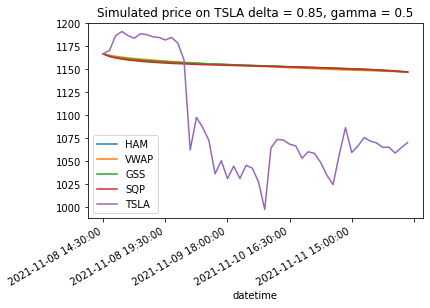

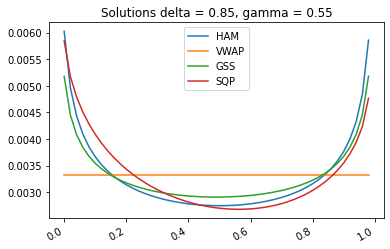

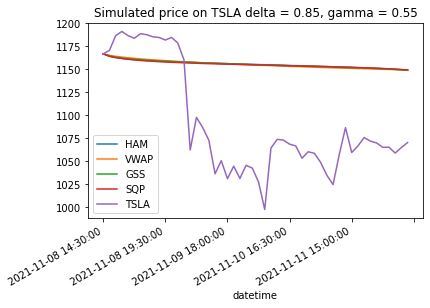

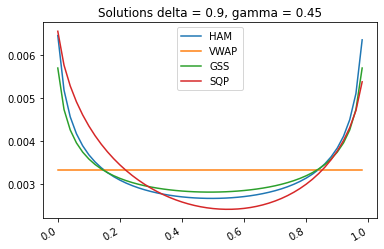

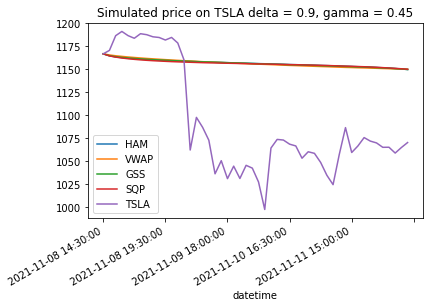

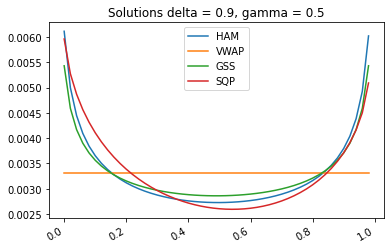

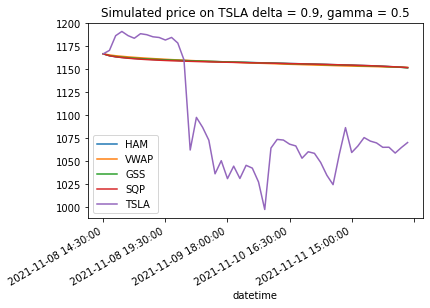

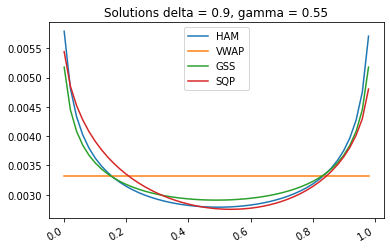

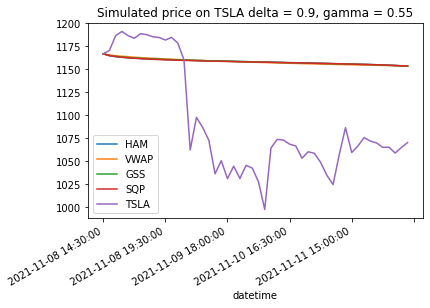

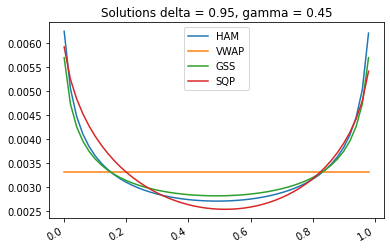

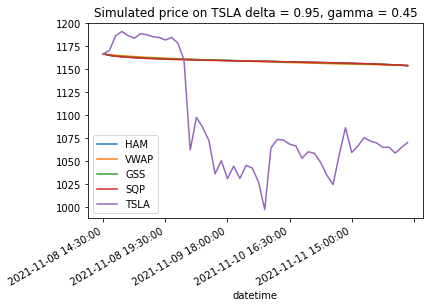

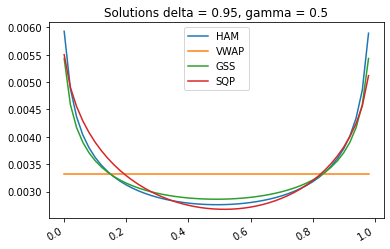

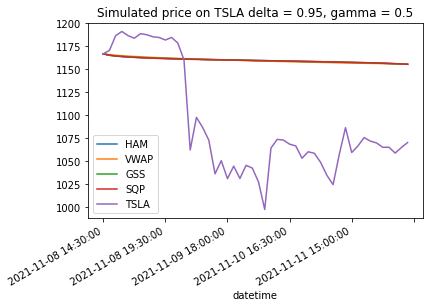

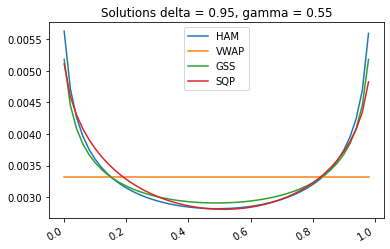

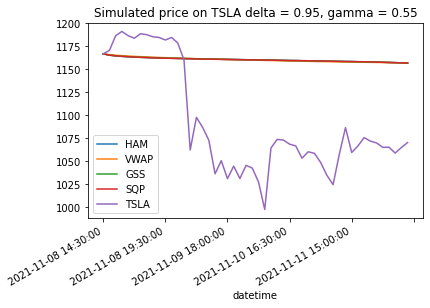

In [17]:
for (delta_val, gamma_val) in ham_dict:
    ham_solution = ham_dict[(delta_val, gamma_val)].solution
    gss_solution = ham_dict[(delta_val, gamma_val)].v_guess
    sqp_solution = sqp_dict[(delta_val, gamma_val)].x
    ham_solution = (-ham_solution / ham_solution.sum()) * X
    gss_solution = (-gss_solution / gss_solution.sum()) * X
    sqp_solution = (-sqp_solution / sqp_solution.sum()) * X
    vwap_solution = np.repeat(-X / N, N)
    ## Compare solution shapes
    pd.Series(-ham_solution, np.arange(0, 1, 0.02)).plot(label = "HAM")
    pd.Series(-vwap_solution, np.arange(0, 1, 0.02)).plot(label = "VWAP")
    pd.Series(-gss_solution, np.arange(0, 1, 0.02)).plot(label = "GSS")
    pd.Series(-sqp_solution, np.arange(0, 1, 0.02)).plot(label = "SQP")
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title(f"Solutions delta = {round(delta_val,2)}, gamma = {round(gamma_val,2)}")
    plt.show()

    ## Simulation on TSLA
    tsla_select = tsla.iloc[::6]
    def get_simulated_price(delta, gamma, solution):
        simulated_price = [tsla_select.close.to_list()[0]]
        scale = 200

        for j in range(1, N):
            local_sum = 0
            for k in range(j):
                local_sum += scale * impact_f(solution[k], delta) * decay_G(j - k, gamma) + wiener_process[k]
            simulated_price.append(local_sum + tsla_select.close.to_list()[0])

        simulated_price = np.array(simulated_price)
        return simulated_price
    
    vwap_simulated_price = get_simulated_price(delta_val, gamma_val, vwap_solution)
    gss_simulated_price = get_simulated_price(delta_val, gamma_val, gss_solution)
    ham_simulated_price = get_simulated_price(delta_val, gamma_val, ham_solution)
    sqp_simulated_price = get_simulated_price(delta_val, gamma_val, sqp_solution)

    pd.Series(ham_simulated_price).plot(label = "HAM")
    pd.Series(vwap_simulated_price).plot(label = "VWAP")
    pd.Series(gss_simulated_price).plot(label = "GSS")
    pd.Series(sqp_simulated_price).plot(label = "SQP")
    tsla_sample.close.plot(label = "TSLA")
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title(f"Simulated price on TSLA delta = {round(delta_val,2)}, gamma = {round(gamma_val,2)}")
    plt.show()